In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from deap.tools import initRepeat
import time # Explicitly import initRepeat


In [ ]:
# Problem Setup
max_length = 50  
actions = [0, 1, 2, 3] 
gap_penalty = -2

# Define Fitness and Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)



# Toolbox Setup
toolbox = base.Toolbox()

# Correctly Register Individual Creation
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, lambda: random.choice(actions), max_length
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the Fitness Function
def eval_alignment(individual):
    score = 0
    for i in range(len(individual) - 1):
        if individual[i] == individual[i + 1]:
            score += 1  # Reward for alignment
        else:
            score += gap_penalty  # Penalize gaps
    return score,

toolbox.register("evaluate", eval_alignment)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(actions)-1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=5)  # Stronger selection pressure


In [3]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
population = toolbox.population(n=300)


# Machine Learning Model Setup
ml_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=2000, random_state=42)
ml_features = []
ml_targets = []
ml_model_fitted = False

In [4]:
# Evolutionary Algorithm Execution
num_generations = 100
mutation_prob = 0.2
fitness_over_time = []
avg_fitness_over_time = []
diversity_over_time = []

In [ ]:
validation_split = 0.2
global_best_fitness = -float('inf') 
global_best_generation = -1

for gen in range(num_generations):
    print(f"Generation {gen}")
    fitnesses = []
    # Calculate Diversity
    diversity = len(set(tuple(ind) for ind in population)) / len(population)
    diversity_over_time.append(diversity)


    for ind in population:
        # Predict fitness using the ML model if applicable
        if gen >= 10 and ml_model_fitted:
            ind_array = np.array(ind).reshape(1, -1)
            predicted_fitness = ml_model.predict(ind_array)[0]
            ind.fitness.values = (predicted_fitness,)
            fitnesses.append(ind.fitness.values[0])
        else:
            # Evaluate fitness normally
            fit = toolbox.evaluate(ind)
            ind.fitness.values = fit
            fitnesses.append(fit[0])

            # Collect data for ML
            ml_features.append(ind.copy())
            ml_targets.append(fit[0])

    # Record Statistics
    max_fit = max(fitnesses)
    avg_fit = sum(fitnesses) / len(fitnesses)
    diversity = len(set(tuple(ind) for ind in population)) / len(population)

    fitness_over_time.append(max_fit)
    diversity_over_time.append(diversity)
    avg_fitness_over_time.append(avg_fit)

    print(f"  Max Fitness: {max_fit}")
    print(f"  Avg Fitness: {avg_fit}")
    print(f"  Diversity: {diversity}")

    if max_fit > global_best_fitness:
        global_best_fitness = max_fit
        global_best_generation = gen


        print(f"Updated Global Best Fitness: {global_best_fitness} at Generation {global_best_generation}")

    # Validation for Best Individual
    if gen >= 10 and ml_model_fitted and abs(max_fit - global_best_fitness) < 1e-6:
        best_individual = tools.selBest(population, 1)[0]
        best_individual_array = np.array(best_individual).reshape(1, -1)

        predicted_fitness = ml_model.predict(best_individual_array)[0]
        actual_fitness = eval_alignment(best_individual)[0]

        print(f"Validation for Best Individual at Generation {gen}:")
        print(f"  Predicted Fitness: {predicted_fitness}")
        print(f"  Actual Fitness: {actual_fitness}")
        print(f"  Error: {abs(predicted_fitness - actual_fitness):.2f}")

        # Calculate Validation Metrics for the Population
        population_array = np.array([np.array(ind) for ind in population])
        predicted_fitnesses = ml_model.predict(population_array)
        actual_fitnesses = [eval_alignment(ind)[0] for ind in population]

        mse = mean_squared_error(actual_fitnesses, predicted_fitnesses)
        r2 = r2_score(actual_fitnesses, predicted_fitnesses)

        print(f"Validation Metrics at Generation {gen}:")
        print(f"  MSE: {mse:.4f}")
        print(f"  R²: {r2:.4f}")

     # Adjust Mutation Probability Based on Diversity
    if gen > 20 and max_fit == fitness_over_time[-1]:
        mutation_prob = 0.5  
    elif diversity < 0.3:  
        mutation_prob = 0.3
    else:
        mutation_prob = 0.2

    # Train ML Model Every 5 Generations
    if (gen + 1) % 5 == 0 and len(ml_features) > 0:
        X = np.array([np.array(ind) for ind in ml_features])
        y = np.array(ml_targets)
        split_index = int(len(X) * (1 - validation_split))
        X_train, X_val = X[:split_index], X[split_index:]
        y_train, y_val = y[:split_index], y[split_index:]

        # Train ML model
        start_time = time.time()
        ml_model.fit(X_train, y_train)
        ml_model_fitted = True
        print(f"  ML Model Trained at Generation {gen} in {time.time() - start_time:.2f} seconds")

        # Compute validation metrics
        y_val_pred = ml_model.predict(X_val)
        mse = mean_squared_error(y_val, y_val_pred)
        r2 = r2_score(y_val, y_val_pred)
        print(f"  Validation Metrics at Generation {gen}:")
        print(f"    MSE: {mse:.2f}")
        print(f"    R²: {r2:.2f}")
        print(f"  ML Model Trained at Generation {gen}")
        print(f"  ML Model Trained at Generation {gen} in {time.time() - start_time:.2f} seconds")
   

    # Apply Genetic Operators
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.7:  # Crossover probability
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:  # Mutation probability
            toolbox.mutate(mutant)
            del mutant.fitness.values

    if gen % 10 == 0:
        new_individuals = [toolbox.individual() for _ in range(20)]
        offspring.extend(new_individuals)

    population[:] = offspring


Generation 0
  Max Fitness: -38
  Avg Fitness: -61.82
  Diversity: 1.0
Updated Global Best Fitness: -38 at Generation 0
Generation 1
  Max Fitness: -23
  Avg Fitness: -51.865625
  Diversity: 0.95625
Updated Global Best Fitness: -23 at Generation 1
Generation 2
  Max Fitness: -20
  Avg Fitness: -43.4375
  Diversity: 0.9125
Updated Global Best Fitness: -20 at Generation 2
Generation 3
  Max Fitness: -17
  Avg Fitness: -36.5375
  Diversity: 0.9
Updated Global Best Fitness: -17 at Generation 3
Generation 4
  Max Fitness: -8
  Avg Fitness: -30.10625
  Diversity: 0.89375
Updated Global Best Fitness: -8 at Generation 4
  ML Model Trained at Generation 4 in 9.36 seconds
  Validation Metrics at Generation 4:
    MSE: 80.59
    R²: -0.35
  ML Model Trained at Generation 4
  ML Model Trained at Generation 4 in 9.36 seconds
Generation 5
  Max Fitness: -5
  Avg Fitness: -23.95625
  Diversity: 0.896875
Updated Global Best Fitness: -5 at Generation 5
Generation 6
  Max Fitness: 7
  Avg Fitness: -18.7

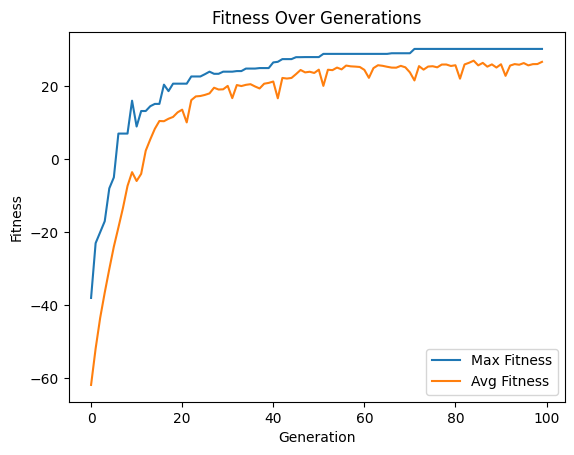

In [7]:
# Plot Fitness Over Time
plt.plot(fitness_over_time, label="Max Fitness")
plt.plot(avg_fitness_over_time, label="Avg Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Over Generations")
plt.legend()
plt.show()


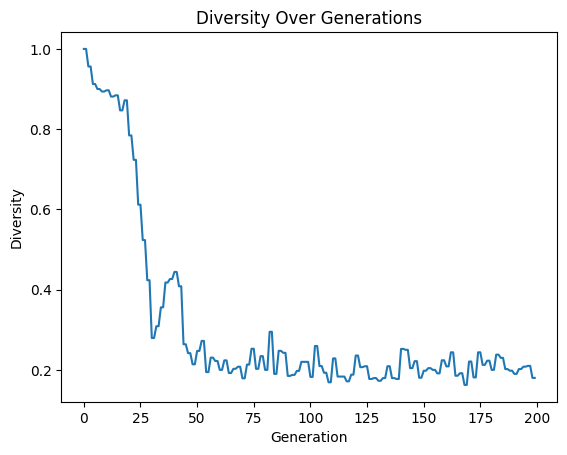

In [8]:
# Plot Diversity Over Time
plt.plot(diversity_over_time)
plt.xlabel("Generation")
plt.ylabel("Diversity")
plt.title("Diversity Over Generations")
plt.show()

In [9]:
# Display Best Individual
best_individual = tools.selBest(population, 1)[0]
print(f"Best Individual: {best_individual}")
print(f"Best Fitness: {best_individual.fitness.values[0]}")

# Validation for Best Individual


Best Individual: [2, 3, 3, 2, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 1, 1, 0, 2]
Best Fitness: 30.179369368859795


In [10]:
print(f"ML Model Fitted: {ml_model_fitted}")
print(f"Population size: {len(population)}")
print(f"Best Individual Fitness: {tools.selBest(population, 1)[0].fitness.values[0]}")
print(f"  max(fitness_over_time): {max(fitness_over_time)}")
print(f"  Condition Result: {gen >= 10 and ml_model_fitted and abs(max_fit - max(fitness_over_time)) < 1e-6}")

if gen >= 10 and ml_model_fitted and abs(max_fit - max(fitness_over_time)) < 1e-6:
  best_individual = tools.selBest(population, 1)[0]
  best_individual_array = np.array(best_individual).reshape(1, -1)

  predicted_fitness = ml_model.predict(best_individual_array)[0]
  actual_fitness = eval_alignment(best_individual)[0]

  print(f"Validation for Best Individual at Generation {gen}:")
  print(f"  Predicted Fitness: {predicted_fitness}")
  print(f"  Actual Fitness: {actual_fitness}")
  print(f"  Error: {abs(predicted_fitness - actual_fitness):.2f}")

ML Model Fitted: True
Population size: 500
Best Individual Fitness: 30.179369368859795
  max(fitness_over_time): 30.179369368859795
  Condition Result: True
Validation for Best Individual at Generation 99:
  Predicted Fitness: 30.179369368859795
  Actual Fitness: -23
  Error: 53.18


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Convert collected data to arrays
X = np.array([np.array(ind) for ind in ml_features])  # Features
y = np.array(ml_targets)  # Targets (alignment scores)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Train Gradient Boosting Regressor (or another ML model)
ml_model = GradientBoostingRegressor()
ml_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ml_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"ML Model RMSE: {rmse:.2f}")
print(f"ML Model R²: {r2:.2f}")


ML Model RMSE: 7.47
ML Model R²: 0.87


In [13]:
# Find the best fitness value
best_ga_fitness = max(fitness_over_time)

# Find the generation where the best fitness was achieved
best_generation = fitness_over_time.index(best_ga_fitness)

print(f"Best GA Fitness: {best_ga_fitness}")
print(f"Achieved at Generation: {best_generation}")



Best GA Fitness: 30.179369368859795
Achieved at Generation: 71


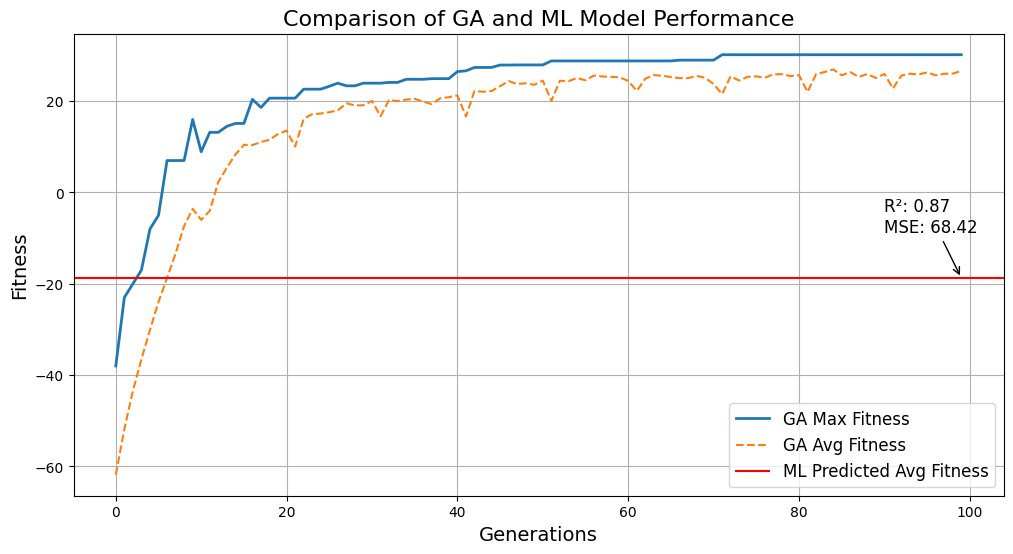

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# GA Fitness Over Time
plt.figure(figsize=(12, 6))
plt.plot(range(len(fitness_over_time)), fitness_over_time, label="GA Max Fitness", linewidth=2)
plt.plot(range(len(avg_fitness_over_time)), avg_fitness_over_time, label="GA Avg Fitness", linestyle='--')

# ML Predicted Fitness
if ml_model_fitted:
    ml_predicted_fitness = ml_model.predict(np.array([np.array(ind) for ind in population]))
    plt.axhline(y=np.mean(ml_predicted_fitness), color='r', linestyle='-', label="ML Predicted Avg Fitness")
    plt.annotate(f"R²: {r2:.2f}\nMSE: {mse:.2f}",
                 xy=(len(fitness_over_time) - 1, np.mean(ml_predicted_fitness)),
                 xytext=(len(fitness_over_time) - 10, np.mean(ml_predicted_fitness) + 10),
                 arrowprops=dict(facecolor='black', arrowstyle="->"),
                 fontsize=12)

# Plot Details
plt.title("Comparison of GA and ML Model Performance", fontsize=16)
plt.xlabel("Generations", fontsize=14)
plt.ylabel("Fitness", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()




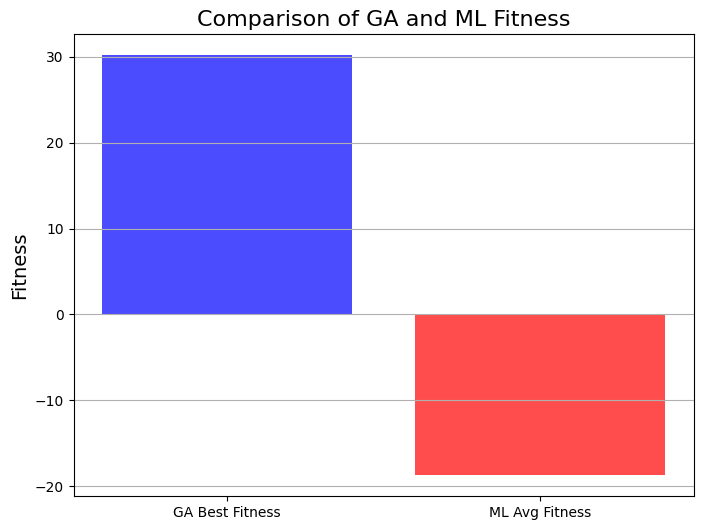

In [21]:
best_ga_fitness = max(fitness_over_time)
avg_ml_fitness = np.mean(ml_predicted_fitness)

methods = ["GA Best Fitness", "ML Avg Fitness"]
values = [best_ga_fitness, avg_ml_fitness]

plt.figure(figsize=(8, 6))
plt.bar(methods, values, color=["blue", "red"], alpha=0.7)
plt.title("Comparison of GA and ML Fitness", fontsize=16)
plt.ylabel("Fitness", fontsize=14)
plt.grid(axis="y")
plt.show()


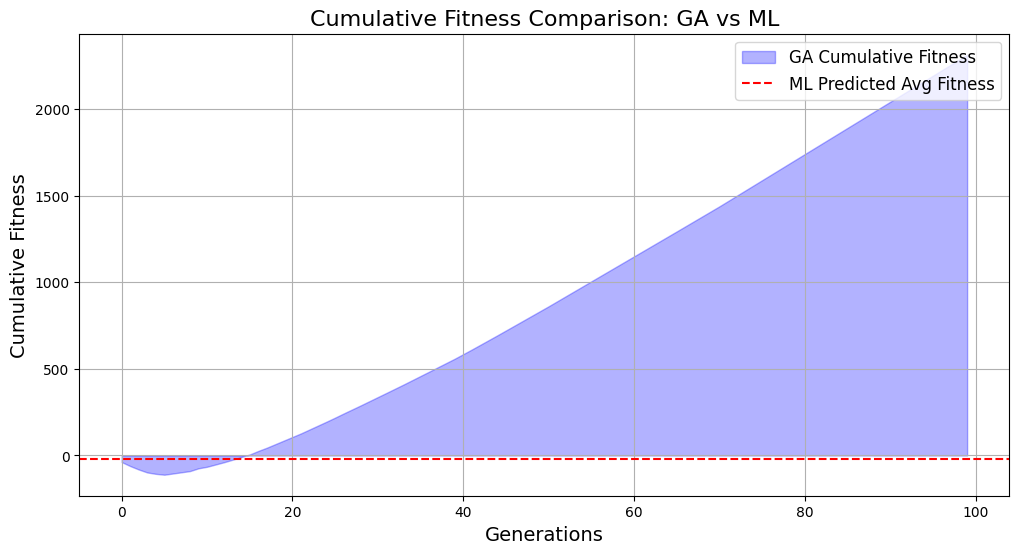

In [22]:
cumulative_fitness = np.cumsum(fitness_over_time)

plt.figure(figsize=(12, 6))
plt.fill_between(range(len(fitness_over_time)), cumulative_fitness, color="blue", alpha=0.3, label="GA Cumulative Fitness")
plt.axhline(y=np.mean(ml_predicted_fitness), color="red", linestyle="--", label="ML Predicted Avg Fitness")

plt.title("Cumulative Fitness Comparison: GA vs ML", fontsize=16)
plt.xlabel("Generations", fontsize=14)
plt.ylabel("Cumulative Fitness", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
